<a href="https://colab.research.google.com/github/CharFox1/CompVisProj/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import torch
import os
import cv2
import numpy as np

In [5]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


In [ ]:
# simple conv network to test finding single characters
# uses resnet-4 structure

class convDemoNet(nn.Module):
  def __init__(self):
    super(convDemoNet, self).__init__()
    self.conv1 = nn.conv2d(batchSize ,1, 32, 32)


In [2]:
!unzip handwrittenChars.zip

Archive:  handwrittenChars.zip
   creating: handwrittenChars/
   creating: handwrittenChars/.ipynb_checkpoints/
  inflating: handwrittenChars/.ipynb_checkpoints/parseHandwrittenChars-checkpoint.ipynb  
  inflating: handwrittenChars/parseHandwrittenChars.ipynb  
  inflating: handwrittenChars/trainSmall.npy  
  inflating: handwrittenChars/valSmall.npy  


training data size: 78000
validation data size: 13209
training data shape: (32, 32)


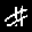

training data label: #
each index in dataset has image (32x32) and char label


In [17]:
# get conv demo data (https://www.kaggle.com/vaibhao/handwritten-characters)
from google.colab.patches import cv2_imshow #allows us to show images

# grab small files (created from larger dataset)
# this is the location they should be in the github
# if you are running in collab, you need to import the handwrittenChars folder as a zip
# you can unzip it with "!unzip handwrittenChars.zip" in a separate cell
with open("handwrittenChars/trainSmall.npy", "rb") as f:
    conv_train_data = np.load(f, allow_pickle=True)

with open("handwrittenChars/valSmall.npy", "rb") as f:
    conv_val_data = np.load(f, allow_pickle=True)

print("training data size:", len(conv_train_data))
print("validation data size:", len(conv_val_data))

print("training data shape:", conv_train_data[1201][0].shape)
cv2_imshow(conv_train_data[1201][0])
print("training data label:", conv_train_data[1201][1])
print("each index in dataset has image (32x32) and char label")

In [19]:
labels = []
for i in conv_train_data:
  label = i[1]
  if label not in labels:
    labels.append(label)

print("there are", len(labels), "labels in the training dataset")

for i in conv_val_data:
  label = i[1]
  if label not in labels:
    labels.append(label)

print("there are", len(labels), "labels in the validation dataset")

there are 39 labels in the training dataset
there are 39 labels in the validation dataset
